In [1]:
import os
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2

import random
import yaml
import json
import os
from bs4 import BeautifulSoup

Три датасета положил в архив https://drive.google.com/file/d/12viYKrIWr9s1efku40CZj5ZqzOcvOQ02/view?usp=sharing, можно добавить ярлык на свой google disk и разархивировать в память колаба (из нее быстрее читает, чем с гугл диска)

In [ ]:
!unzip -q /content/drive/MyDrive/datasets.zip

##Датасет для распознавания номеров

Тут надо подумать какую модель мы будем обучать и в каком виде нужен label

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_names = os.listdir(img_dir)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = read_image(img_path)
        label = self.img_names[idx][:-4]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
training_data = CustomImageDataset('./plates/train/')
valid_data = CustomImageDataset('./plates/valid/')

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)

##Датасет для детекции транспорта

Для детекции подготовил данные в формате для Yolo_v5 https://github.com/ultralytics/yolov5
Тут датасет большой, я добавил только пятую часть, если что можно будет добавить

In [ ]:
# создаем yaml файл

yaml_file = {'train':'./cars_detection/images/train' ,
            'val': './cars_detection/images/valid',
            'nc' : '11',
            'names' : ['bus', 'car', 'motorized_vehicle', 'articulated_truck', 'pickup_truck', 'single_unit_truck', 
                       'work_van', 'pedestrian', 'bicycle', 'non-motorized_vehicle', 'motorcycle']}

with open('vehicle_detection.yaml', 'w') as file:
    documents = yaml.dump(yaml_file, file)

##Датасет для детекции номеров

In [ ]:
# создаем yaml файл

yaml_file = {'train':'./plates_detection/images/train' ,
            'val': './plates_detection/images/valid',
            'nc' : '1',
            'names' : ['0']}

with open('plates_detection.yaml', 'w') as file:
    documents = yaml.dump(yaml_file, file)

### Подготовка датасета

In [25]:
from PIL import Image
import random
import yaml
import json
import os
from bs4 import BeautifulSoup
import shutil
from sklearn.model_selection import train_test_split

In [5]:
#Проходим по всем файлам аннотаций, меняем формат боксов и записываем в файл
for name in os.listdir('/content/annotations'):
  with open('/content/annotations/'+name, 'r') as file:
    xml_file = file.read() 
    soup = BeautifulSoup(xml_file, 'lxml') 
    size = soup.find("size")
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    for tag in soup.findAll("object"): 
      cls = 0
      xmin = int(tag.find("xmin").text)
      ymin = int(tag.find("ymin").text)
      xmax = int(tag.find("xmax").text)
      ymax = int(tag.find("ymax").text) 

      w = xmax - xmin #вычисляем ширину бокса
      h = ymax - ymin #вычисляем высоту бокса
      x = xmin + (w / 2) #находим центр бокса по ширине
      y = ymin + (h / 2) #находим центр бокса по высоте

      #нормируем значения
      x = round(x / width , 4)
      w = round(w / width , 4)
      y = round(y / height, 4)
      h = round(h / height, 4)
      
      #записываем в файл
      with open('/content/drive/MyDrive/plates_recognition/labels/'+name[:-3]+'txt', 'a') as f:
        f.write('{} {} {} {} {}\n'.format(cls, x, y, w, h))


In [67]:
!zip -q /content/labels


zip error: Nothing to do! (/content/labels.zip)


In [27]:
name_list = os.listdir('/content/drive/MyDrive/plates_recognition/labels')
train_list, test_list = train_test_split(name_list, test_size=0.1)
train_list, val_list = train_test_split(train_list, test_size=0.25)

print('Обучающая выборка: ',len(train_list))
print('Проверочная выборка: ',len(val_list))
print('Тестовая выборка:' ,len(test_list))

Обучающая выборка:  754
Проверочная выборка:  252
Тестовая выборка: 112


In [ ]:
sorted(val_list)

In [33]:
!mkdir '/content/drive/MyDrive/plates_recognition/labels/train/'
!mkdir '/content/drive/MyDrive/plates_recognition/labels/valid/'
!mkdir '/content/drive/MyDrive/plates_recognition/labels/test/'

In [34]:
def move_data(name_list, folder, mode):
  """
  Функция перемещает файлы в указанную папку.
  name_list - список с названиями файлов для перемещения
  folder    - путь к папке откуда берем файл
  mode      - название папки куда перемещаем
  img       - указывает какой тип файла мы перемещаем 
  """
  for name in name_list:
    shutil.move(folder + name, folder + '{}/'.format(mode) + name)

In [35]:
move_data(train_list, '/content/drive/MyDrive/plates_recognition/labels/', 'train')
move_data(val_list, '/content/drive/MyDrive/plates_recognition/labels/', 'valid')
move_data(test_list, '/content/drive/MyDrive/plates_recognition/labels/', 'test')

In [ ]:
# class CustomImageDataset(Dataset):
#     def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         self.img_labels = pd.read_csv(annotations_file)
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

In [ ]:
# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

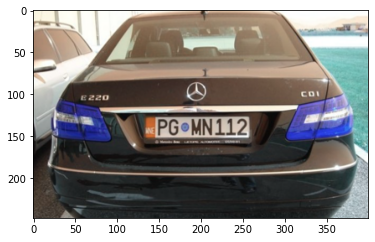

In [17]:
img = cv2.imread('/content/Cars1.png')
plt.imshow(img)

In [18]:
img.shape

(248, 400, 3)

In [19]:
x = 0.495 * 400
y = 0.5806 * 248
w = 0.32 * 400
h = 0.129 * 248

In [48]:
print(x,y,w,h)

183.9903 415.5046 208.02339999999998 66.9908


In [20]:
h_min = y-h/2
h_max = y+h/2
w_min = x-w/2
w_max = x+w/2

In [46]:
print(h_min,h_max,w_min,w_max)

420.2952 494.0 72.69310000000002 261.767


In [21]:
start_point = (int(w_min), int(h_max))
end_point = (int(w_max), int(h_min))

In [22]:
image1 = cv2.rectangle(img, start_point, end_point, (0, 255, 0), 2)


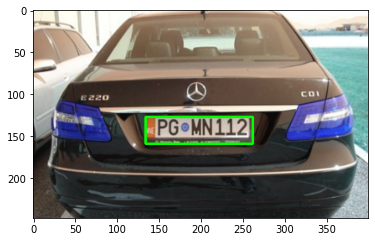

In [23]:
plt.imshow(image1)

In [42]:
df = pd.read_csv('/content/gt_train.csv', header=None)

In [59]:
venocle = df.sort_values(by=0).iloc[:20000,:]

In [60]:
venocle

,0,1,2,3,4,5
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45
...,...,...,...,...,...,...
19995,6319,car,0,151,62,189
19996,6320,car,312,36,472,133
19997,6320,car,118,41,220,93
19998,6321,car,0,225,188,360
